In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels
import sklearn
import xgboost as xgb
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
sns.set_palette('husl')

print("✅ All libraries loaded successfully!")

✅ All libraries loaded successfully!


In [4]:
import os

downloads = os.path.join(os.path.expanduser('~'), 'Downloads')

# List all files in Downloads that have 'household' or 'power' in the name
for f in os.listdir(downloads):
    if 'household' in f.lower() or 'power' in f.lower():
        print(f)

individual+household+electric+power+consumption.zip


In [5]:
import zipfile

downloads = os.path.join(os.path.expanduser('~'), 'Downloads')
zip_path = os.path.join(downloads, 'individual+household+electric+power+consumption.zip')

# Unzip the file into your Downloads folder
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(downloads)
    print("Extracted files:")
    for name in z.namelist():
        print(f"  → {name}")

print("\n✅ File unzipped successfully!")

Extracted files:
  → household_power_consumption.txt

✅ File unzipped successfully!


In [6]:
file_path = os.path.join(os.path.expanduser('~'), 'Downloads', 'household_power_consumption.txt')

df = pd.read_csv(file_path, sep=';', low_memory=False)

print(f"✅ Dataset loaded successfully!")
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

✅ Dataset loaded successfully!
Rows: 2075259
Columns: 9


In [7]:
# Show the first 5 rows of the dataset
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [8]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [9]:
## data type being object means there are non numerical values in certain categories that need to be cleaned up.

In [10]:
# Step 1: Replace '?' (missing values in this dataset) with NaN
df = df.replace('?', np.nan)

# Step 2: Convert number columns from text to actual numbers
number_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                  'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']

for col in number_columns:
    df[col] = pd.to_numeric(df[col])

# Step 3: Combine Date and Time into one proper datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Step 4: Check how many missing values we have
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing rows: {df.isnull().any(axis=1).sum()} out of {len(df)} ({df.isnull().any(axis=1).mean()*100:.2f}%)")

Missing values per column:
Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Datetime                     0
dtype: int64

Total missing rows: 25979 out of 2075259 (1.25%)


In [11]:
# Drop rows with missing values
df = df.dropna()

# Set Datetime as our index (this makes time-series work much easier)
df = df.set_index('Datetime')

# Drop the old Date and Time columns since we don't need them anymore
df = df.drop(columns=['Date', 'Time'])

print(f"✅ Cleaned dataset:")
print(f"Rows remaining: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumn types:")
print(df.dtypes)

✅ Cleaned dataset:
Rows remaining: 2049280
Columns: 7
Date range: 2006-12-16 17:24:00 to 2010-11-26 21:02:00

Column types:
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [12]:
# The original data has a reading every single minute - that's too detailed
# We'll resample to HOURLY averages to make it more manageable
# Think of it like zooming out on a map - we see the big picture better

df_hourly = df.resample('h').mean()

print(f"Original data: {df.shape[0]} rows (every minute)")
print(f"Hourly data: {df_hourly.shape[0]} rows (every hour)")
print(f"\nFirst few rows:")
df_hourly.head()

Original data: 2049280 rows (every minute)
Hourly data: 34589 rows (every hour)

First few rows:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


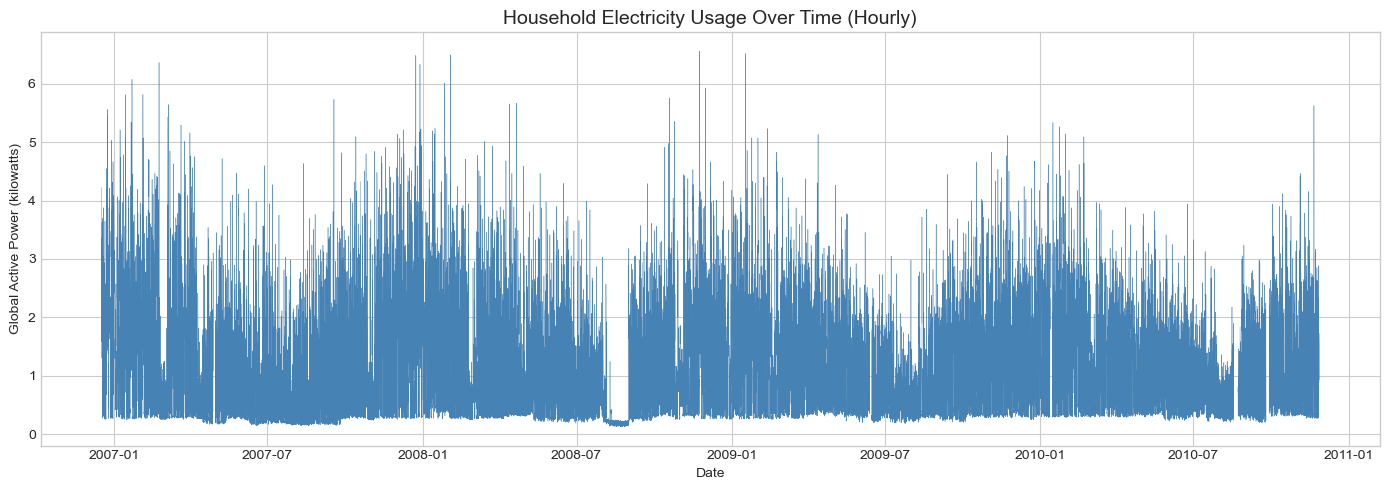

In [13]:
# This plots the electricity usage over the entire date range
# It helps us spot trends - does usage go up in winter? Are there patterns?

plt.figure(figsize=(14, 5))
plt.plot(df_hourly.index, df_hourly['Global_active_power'], linewidth=0.3, color='steelblue')
plt.title('Household Electricity Usage Over Time (Hourly)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.tight_layout()
plt.show()

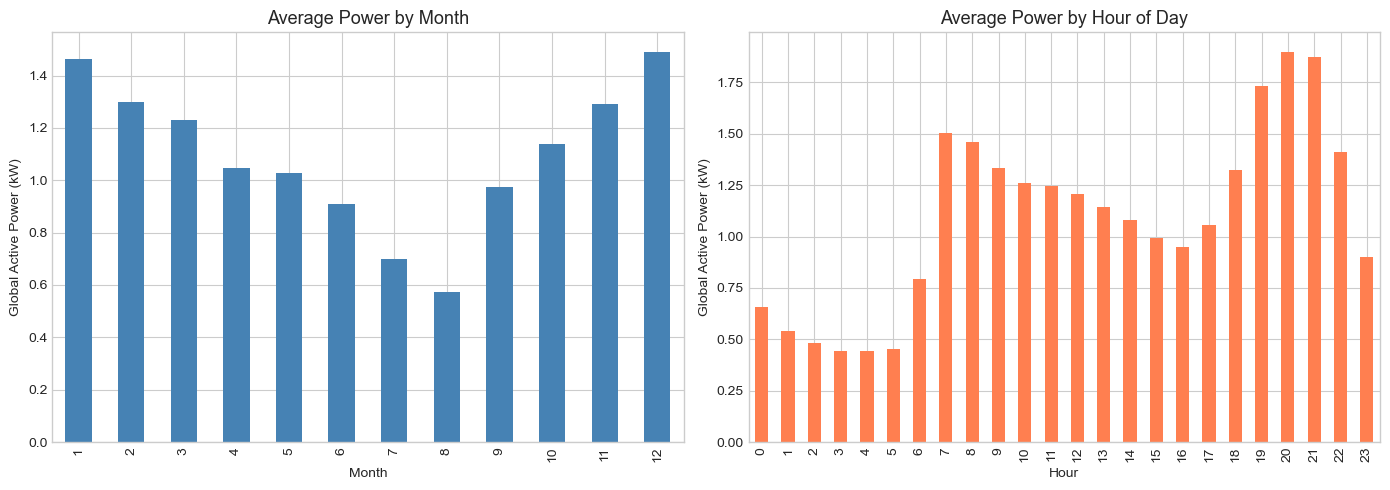

In [14]:
# Let's see the AVERAGE usage by month and by hour of day
# This helps us confirm the seasonal and daily patterns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left chart: Average usage by MONTH (1=January, 12=December)
df_hourly.groupby(df_hourly.index.month)['Global_active_power'].mean().plot(
    kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Average Power by Month', fontsize=13)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Global Active Power (kW)')

# Right chart: Average usage by HOUR OF DAY (0=midnight, 23=11pm)
df_hourly.groupby(df_hourly.index.hour)['Global_active_power'].mean().plot(
    kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Average Power by Hour of Day', fontsize=13)
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Global Active Power (kW)')

plt.tight_layout()
plt.show()

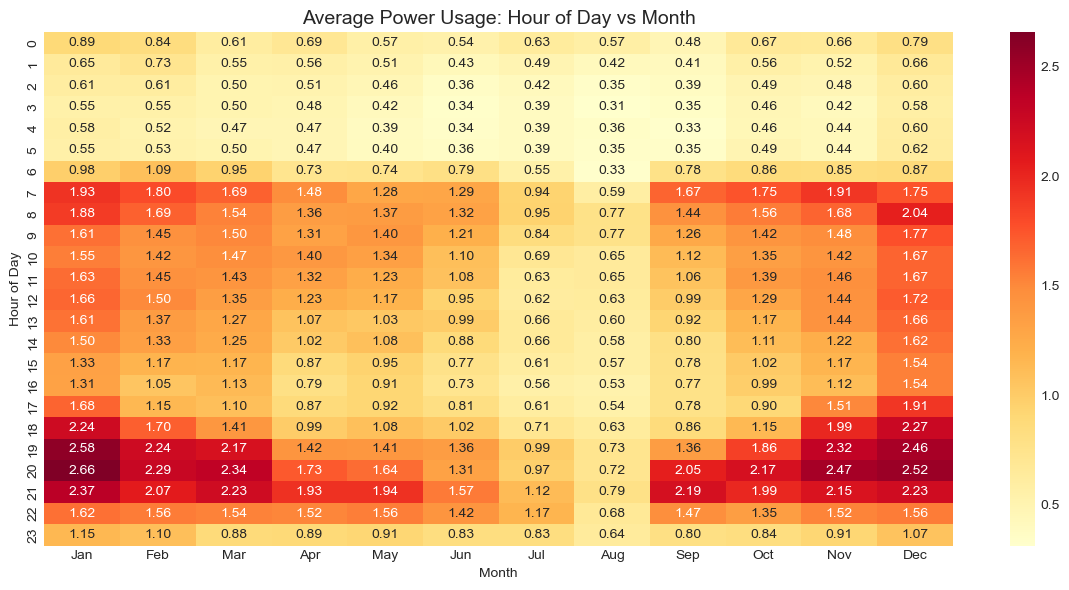

In [15]:
# This heatmap shows average power usage for every combination of hour and month
# Dark colors = high usage, light colors = low usage
# It combines both patterns into one picture

pivot = df_hourly.pivot_table(
    values='Global_active_power', 
    index=df_hourly.index.hour, 
    columns=df_hourly.index.month, 
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.2f', 
            xticklabels=['Jan','Feb','Mar','Apr','May','Jun',
                         'Jul','Aug','Sep','Oct','Nov','Dec'],
            yticklabels=range(0,24))
plt.title('Average Power Usage: Hour of Day vs Month', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()

In [16]:
# FEATURE ENGINEERING
# We're creating new columns from the datetime index
# These give the model the "clues" it needs to learn patterns

df_hourly['hour'] = df_hourly.index.hour              # 0-23 (midnight to 11pm)
df_hourly['day_of_week'] = df_hourly.index.dayofweek  # 0=Monday, 6=Sunday
df_hourly['month'] = df_hourly.index.month             # 1-12 (January to December)
df_hourly['day_of_year'] = df_hourly.index.dayofyear   # 1-365
df_hourly['week_of_year'] = df_hourly.index.isocalendar().week.astype(int)  # 1-52
df_hourly['is_weekend'] = (df_hourly.index.dayofweek >= 5).astype(int)     # 1=weekend, 0=weekday

print("✅ New features created!")
print(f"\nColumns now: {list(df_hourly.columns)}")
print(f"\nFirst few rows with new features:")
df_hourly[['Global_active_power','hour','day_of_week','month','is_weekend']].head(10)

✅ New features created!

Columns now: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'day_of_week', 'month', 'day_of_year', 'week_of_year', 'is_weekend']

First few rows with new features:


,Global_active_power,hour,day_of_week,month,is_weekend
Datetime,,,,,
2006-12-16 17:00:00,4.222889,17,5,12,1
2006-12-16 18:00:00,3.632200,18,5,12,1
2006-12-16 19:00:00,3.400233,19,5,12,1
2006-12-16 20:00:00,3.268567,20,5,12,1
2006-12-16 21:00:00,3.056467,21,5,12,1
2006-12-16 22:00:00,2.200133,22,5,12,1
2006-12-16 23:00:00,2.061600,23,5,12,1
2006-12-17 00:00:00,1.882467,0,6,12,1
2006-12-17 01:00:00,3.349400,1,6,12,1


In [17]:
# TRAIN / TEST SPLIT
# We use everything BEFORE 2010 to train, and 2010 onward to test
# This simulates real life: learn from the past, predict the future

# Define our features (the clues) and target (what we want to predict)
features = ['hour', 'day_of_week', 'month', 'day_of_year', 'week_of_year', 'is_weekend']
target = 'Global_active_power'

# Split by date
train = df_hourly[df_hourly.index < '2010-01-01']
test = df_hourly[df_hourly.index >= '2010-01-01']

# Separate features (X) and target (y) for both sets
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

print(f"Training data: {X_train.shape[0]} hours ({train.index.min().date()} to {train.index.max().date()})")
print(f"Testing data:  {X_test.shape[0]} hours ({test.index.min().date()} to {test.index.max().date()})")
print(f"\nFeatures used: {features}")
print(f"Target: {target}")

Training data: 26671 hours (2006-12-16 to 2009-12-31)
Testing data:  7918 hours (2010-01-01 to 2010-11-26)

Features used: ['hour', 'day_of_week', 'month', 'day_of_year', 'week_of_year', 'is_weekend']
Target: Global_active_power


In [19]:
# Remove any rows with missing values from our hourly data
df_hourly = df_hourly.dropna()

# Redo the train/test split with the cleaned data
train = df_hourly[df_hourly.index < '2010-01-01']
test = df_hourly[df_hourly.index >= '2010-01-01']

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

print(f"✅ Cleaned! No more missing values.")
print(f"Training data: {X_train.shape[0]} hours")
print(f"Testing data:  {X_test.shape[0]} hours")

✅ Cleaned! No more missing values.
Training data: 26541 hours
Testing data:  7627 hours


In [20]:
# MODEL 1: LINEAR REGRESSION
# This draws a "best fit" straight line through the data
# It's simple but gives us a baseline to compare other models against

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test data
lr_predictions = lr_model.predict(X_test)

# Measure how accurate the predictions are
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
lr_r2 = r2_score(y_test, lr_predictions)

print("📊 Linear Regression Results:")
print(f"   MAE:  {lr_mae:.4f} kW  (on average, predictions are off by this much)")
print(f"   RMSE: {lr_rmse:.4f} kW  (penalizes big errors more heavily)")
print(f"   R²:   {lr_r2:.4f}      (1.0 = perfect, 0.0 = useless)")

📊 Linear Regression Results:
   MAE:  0.5989 kW  (on average, predictions are off by this much)
   RMSE: 0.7432 kW  (penalizes big errors more heavily)
   R²:   0.0968      (1.0 = perfect, 0.0 = useless)


In [21]:
# MODEL 2: RANDOM FOREST
# Instead of one straight line, this builds 100 decision trees
# Each tree learns a different part of the pattern, then they vote on the answer
# Think of it like asking 100 experts and averaging their opinions

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

print("🌲 Random Forest Results:")
print(f"   MAE:  {rf_mae:.4f} kW")
print(f"   RMSE: {rf_rmse:.4f} kW")
print(f"   R²:   {rf_r2:.4f}")
print(f"\n📈 Improvement over Linear Regression:")
print(f"   MAE improved by {((lr_mae - rf_mae) / lr_mae) * 100:.1f}%")
print(f"   R² improved from {lr_r2:.4f} to {rf_r2:.4f}")

🌲 Random Forest Results:
   MAE:  0.5048 kW
   RMSE: 0.7051 kW
   R²:   0.1871

📈 Improvement over Linear Regression:
   MAE improved by 15.7%
   R² improved from 0.0968 to 0.1871


In [22]:
# MODEL 3: XGBOOST
# The most advanced model - it builds trees one at a time
# Each new tree focuses on fixing the mistakes of the previous ones
# Like a student who reviews their wrong answers after each practice test

xgb_model = xgb.XGBRegressor(
    n_estimators=200,       # Build 200 trees
    max_depth=6,            # How complex each tree can be
    learning_rate=0.1,      # How much each new tree corrects mistakes
    random_state=42
)
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)

print("🚀 XGBoost Results:")
print(f"   MAE:  {xgb_mae:.4f} kW")
print(f"   RMSE: {xgb_rmse:.4f} kW")
print(f"   R²:   {xgb_r2:.4f}")
print(f"\n📈 Improvement over Linear Regression:")
print(f"   MAE improved by {((lr_mae - xgb_mae) / lr_mae) * 100:.1f}%")
print(f"   R² improved from {lr_r2:.4f} to {xgb_r2:.4f}")

🚀 XGBoost Results:
   MAE:  0.4701 kW
   RMSE: 0.6528 kW
   R²:   0.3031

📈 Improvement over Linear Regression:
   MAE improved by 21.5%
   R² improved from 0.0968 to 0.3031


In [23]:
# LAG FEATURES
# We tell the model what the power usage was in previous hours
# Like looking in the rearview mirror to predict what's ahead

df_hourly['lag_1h'] = df_hourly['Global_active_power'].shift(1)    # Usage 1 hour ago
df_hourly['lag_2h'] = df_hourly['Global_active_power'].shift(2)    # Usage 2 hours ago
df_hourly['lag_24h'] = df_hourly['Global_active_power'].shift(24)  # Usage same hour yesterday
df_hourly['lag_168h'] = df_hourly['Global_active_power'].shift(168) # Usage same hour last week

# Rolling average: smooths out the last 24 hours into one number
df_hourly['rolling_24h'] = df_hourly['Global_active_power'].rolling(window=24).mean()

# Drop rows with missing values created by the shifts
df_hourly = df_hourly.dropna()

# Update features list with the new lag features
features_v2 = features + ['lag_1h', 'lag_2h', 'lag_24h', 'lag_168h', 'rolling_24h']

# Redo train/test split
train = df_hourly[df_hourly.index < '2010-01-01']
test = df_hourly[df_hourly.index >= '2010-01-01']
X_train2 = train[features_v2]
y_train2 = train[target]
X_test2 = test[features_v2]
y_test2 = test[target]

print("✅ Lag features created!")
print(f"Features now: {features_v2}")
print(f"Training: {X_train2.shape[0]} hours | Testing: {X_test2.shape[0]} hours")

✅ Lag features created!
Features now: ['hour', 'day_of_week', 'month', 'day_of_year', 'week_of_year', 'is_weekend', 'lag_1h', 'lag_2h', 'lag_24h', 'lag_168h', 'rolling_24h']
Training: 26373 hours | Testing: 7627 hours


In [24]:
# RETRAIN ALL 3 MODELS WITH LAG FEATURES
# Now the models have memory of past usage - this should help a lot

# Model 1: Linear Regression
lr_model2 = LinearRegression()
lr_model2.fit(X_train2, y_train2)
lr_pred2 = lr_model2.predict(X_test2)
lr_r2_v2 = r2_score(y_test2, lr_pred2)
lr_mae_v2 = mean_absolute_error(y_test2, lr_pred2)

# Model 2: Random Forest
rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model2.fit(X_train2, y_train2)
rf_pred2 = rf_model2.predict(X_test2)
rf_r2_v2 = r2_score(y_test2, rf_pred2)
rf_mae_v2 = mean_absolute_error(y_test2, rf_pred2)

# Model 3: XGBoost
xgb_model2 = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model2.fit(X_train2, y_train2)
xgb_pred2 = xgb_model2.predict(X_test2)
xgb_r2_v2 = r2_score(y_test2, xgb_pred2)
xgb_mae_v2 = mean_absolute_error(y_test2, xgb_pred2)

# Compare before and after
print("=" * 60)
print("        R² SCORES: BEFORE vs AFTER LAG FEATURES")
print("=" * 60)
print(f"  Linear Regression:  {lr_r2:.4f}  →  {lr_r2_v2:.4f}")
print(f"  Random Forest:      {rf_r2:.4f}  →  {rf_r2_v2:.4f}")
print(f"  XGBoost:            {xgb_r2:.4f}  →  {xgb_r2_v2:.4f}")
print("=" * 60)
print(f"\n🏆 Best model: XGBoost with R² = {xgb_r2_v2:.4f}")

        R² SCORES: BEFORE vs AFTER LAG FEATURES
  Linear Regression:  0.0968  →  0.5331
  Random Forest:      0.1871  →  0.5944
  XGBoost:            0.3031  →  0.6078

🏆 Best model: XGBoost with R² = 0.6078


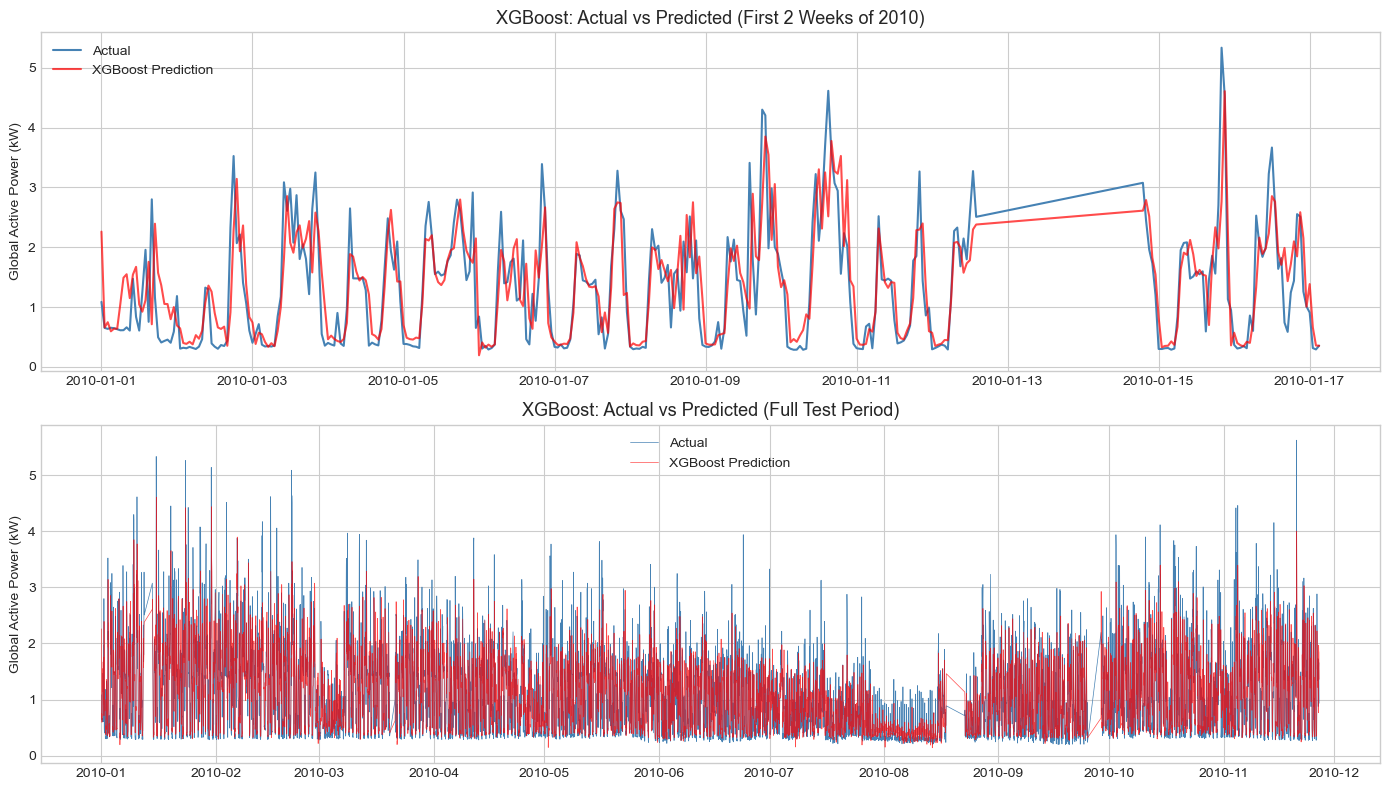

In [25]:
# Let's plot 2 weeks of actual vs predicted values
# This lets us visually see how closely the model follows real usage

two_weeks = 24 * 14  # 14 days worth of hourly data

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Top chart: First 2 weeks of test data zoomed in
axes[0].plot(y_test2.index[:two_weeks], y_test2.values[:two_weeks], 
             label='Actual', color='steelblue', linewidth=1.5)
axes[0].plot(y_test2.index[:two_weeks], xgb_pred2[:two_weeks], 
             label='XGBoost Prediction', color='red', linewidth=1.5, alpha=0.7)
axes[0].set_title('XGBoost: Actual vs Predicted (First 2 Weeks of 2010)', fontsize=13)
axes[0].set_ylabel('Global Active Power (kW)')
axes[0].legend()

# Bottom chart: Full test period
axes[1].plot(y_test2.index, y_test2.values, 
             label='Actual', color='steelblue', linewidth=0.5)
axes[1].plot(y_test2.index, xgb_pred2, 
             label='XGBoost Prediction', color='red', linewidth=0.5, alpha=0.7)
axes[1].set_title('XGBoost: Actual vs Predicted (Full Test Period)', fontsize=13)
axes[1].set_ylabel('Global Active Power (kW)')
axes[1].legend()

plt.tight_layout()
plt.show()

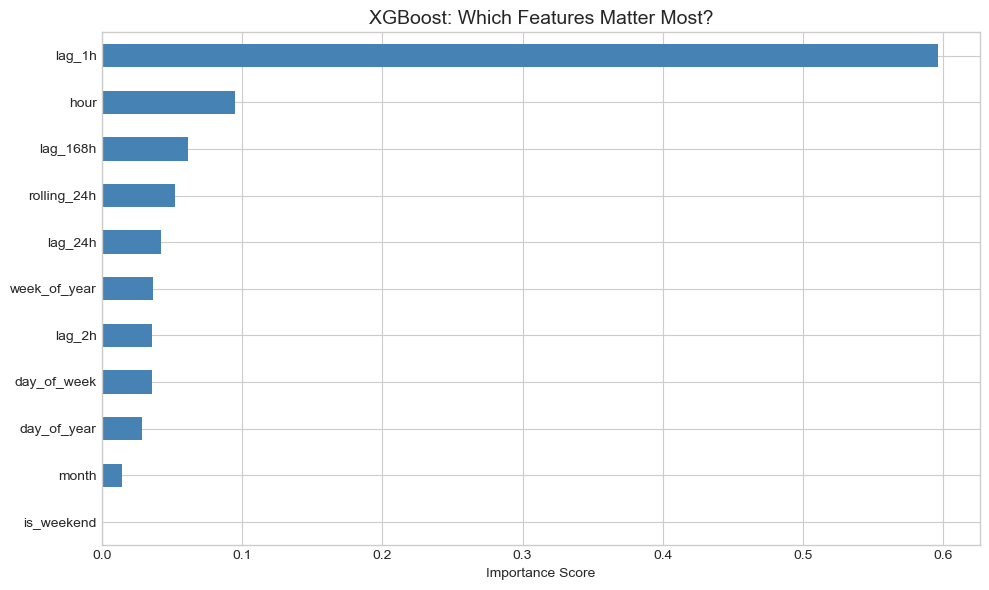

In [26]:
# FEATURE IMPORTANCE
# This shows which features XGBoost found most useful for predictions
# Higher bar = the model relies on this feature more

importance = pd.Series(xgb_model2.feature_importances_, index=features_v2)
importance = importance.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
importance.plot(kind='barh', color='steelblue')
plt.title('XGBoost: Which Features Matter Most?', fontsize=14)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()